In [1]:
# Swinburne University COS80027 Machine Learning final project
# Creator: Horace Lai
# contributions: self-assessment of factor 1 for Horace & Qiyuan
# Initalized: 12-06-2021
# Project: State of the art Model in UCF101 dataset


import os
import time
import math
import numpy as np
from tqdm import tqdm
import pandas as pd 
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model, Input, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, TimeDistributed, LSTM, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report

strategy = tf.distribute.MirroredStrategy()

print ("#" * 100)
print ('Number of devices: {}'.format(strategy.num_replicas_in_sync))
print ("#" * 100)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
####################################################################################################
Number of devices: 1
####################################################################################################


In [2]:
VERSION = 20000
EPOCHS = 100
BATCH_SIZE = 32
input_size = 2, 224, 224, 3
sec_path = './training_result/'

In [3]:
def get_frames(images):
    frames=[]
    for i in tqdm(np.arange(len(images))):
        vid_name = images[i].split('.')[0].split('frame')[0]
        frames_to_select=[]
        for l in np.arange(0, 2):
            frames_to_select.append('frame%d.jpeg' % l)
        vid_data=[]
        for frame in frames_to_select:                
            frame_image = image.load_img(vid_name + frame, target_size=(224, 224))
            frame_image = image.img_to_array(frame_image)
            frame_image = preprocess_input(frame_image)        
            datu=np.asarray(frame_image)
            normu_dat=datu/255
            vid_data.append(normu_dat)
        vid_data=np.array(vid_data)
        frames.append(vid_data)    
    return np.array(frames)

In [4]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return     
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    fig = plt.figure(figsize=(16,10))
    
    ## Loss
    fig.add_subplot(2,1,1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    fig.add_subplot(2,1,2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(sec_path + 'training_history_v%d.png'%VERSION)
    plt.show()    

In [5]:
def pre_trained_ResNet50():    
    #resnet_weights_path = './resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in resnet_model.layers:
        layer.trainable = False
    return resnet_model

In [6]:
def get_compiled_model():   
    ResNet50 = pre_trained_ResNet50()
      
    intermediate_model= Model(inputs=ResNet50.input, outputs=ResNet50.get_layer('conv5_block3_out').output)
    input_tensor = Input(shape=input_size)
    timeDistributed_layer = TimeDistributed(intermediate_model)(input_tensor)
    timeDistributed_layer = TimeDistributed(Flatten())(timeDistributed_layer)
    #lstm_layer = LSTM(1024,return_sequences=False,dropout=0.5)(timeDistributed_layer)
    #MLP_layer = Dense(1024)(lstm_layer)    
    #MLP_layer = Dense(768)(MLP_layer)
    #MLP_layer = Dense(512)(timeDistributed_layer)
    #MLP_layer = Dense(256)(MLP_layer)    
    Flatten_layer = Flatten()(timeDistributed_layer)
    output_layer = Dense(y.shape[1], activation='softmax')(Flatten_layer)    
    
    final_model = Model(inputs = input_tensor, outputs = output_layer)
    print(final_model.summary())
    
    return final_model

In [7]:
images = sorted(glob("UCF_10_1/*.jpeg"))

train_image = []
train_class = []
for i in range(len(images)):    
    train_image.append(images[i].split('\\')[-1])    
    train_class.append(images[i].split('\\')[-1].split('_')[0])
    
# storing the images and their class in a dataframe
train_data = pd.DataFrame()
train_data['image'] = train_image
train_data['class'] = train_class

# save csv file for future use 
train_data.to_csv('train_new.csv',header=True, index=False)

X = get_frames(images)
y = pd.get_dummies(train_data['class'])
#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()
#encoded_labels = le.fit_transform(train_data['class'])
#y = pd.get_dummies(encoded_labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

100%|███████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 193.23it/s]


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2, 224, 224, 3)]  0         
_________________________________________________________________
time_distributed (TimeDistri (None, 2, 7, 7, 2048)     23587712  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 2, 100352)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 10)                2007050   
Total params: 25,594,762
Trainable params: 2,007,050
Non-trainable params: 23,587,712
_________________________________________________________________
None
Epoch 1/100
4/4 [==============================] - 13s 3s/step - loss: 2.8599 - accuracy: 0.1441 - v

4/4 [==============================] - 11s 3s/step - loss: 0.0801 - accuracy: 1.0000 - val_loss: 0.1090 - val_accuracy: 1.0000
Epoch 53/100
4/4 [==============================] - 11s 3s/step - loss: 0.0701 - accuracy: 1.0000 - val_loss: 0.1036 - val_accuracy: 1.0000
Epoch 54/100
4/4 [==============================] - 10s 3s/step - loss: 0.0708 - accuracy: 1.0000 - val_loss: 0.1005 - val_accuracy: 1.0000
Epoch 55/100
4/4 [==============================] - 11s 3s/step - loss: 0.0673 - accuracy: 1.0000 - val_loss: 0.0991 - val_accuracy: 1.0000
Epoch 56/100
4/4 [==============================] - 11s 3s/step - loss: 0.0662 - accuracy: 1.0000 - val_loss: 0.0998 - val_accuracy: 1.0000
Epoch 57/100
4/4 [==============================] - 11s 3s/step - loss: 0.0681 - accuracy: 1.0000 - val_loss: 0.0963 - val_accuracy: 1.0000
Epoch 58/100
4/4 [==============================] - 11s 3s/step - loss: 0.0654 - accuracy: 1.0000 - val_loss: 0.0943 - val_accuracy: 1.0000
Epoch 59/100
4/4 [===============

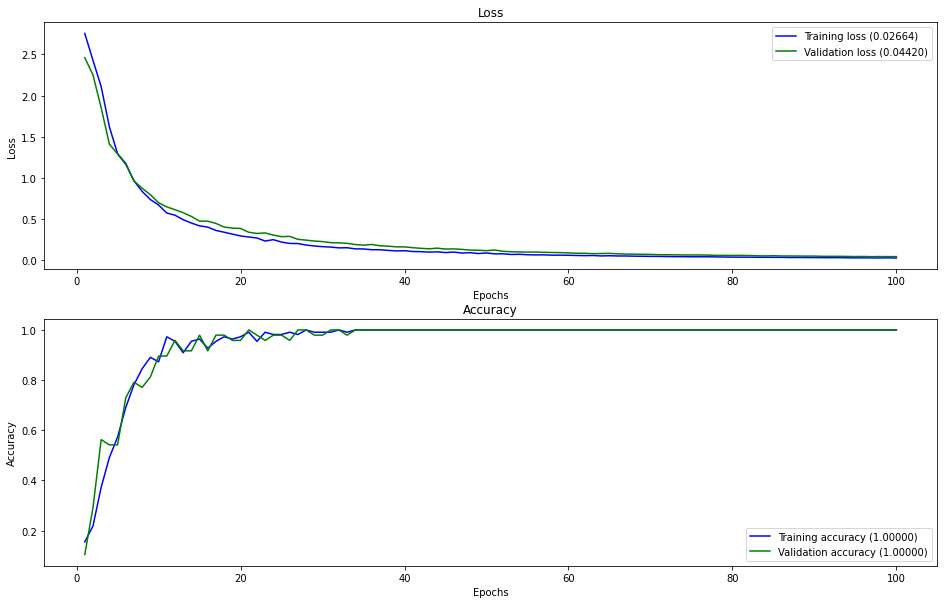

In [8]:
with strategy.scope():    
    
    final_model = get_compiled_model()
    final_model.compile(optimizers.Adam(lr=0.0001),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
    model_checkpoint_callback = ModelCheckpoint(sec_path + 'weight_v%d.hdf5'%VERSION, save_best_only=True, monitor='val_loss', mode='min')
    es_callback = EarlyStopping(monitor='loss', patience=3)

# fit model
    start_time = time.time()
    history = final_model.fit(X_train, y_train, epochs=EPOCHS, 
                        validation_data=(X_test, y_test), batch_size=BATCH_SIZE, callbacks=[model_checkpoint_callback, es_callback])
    
    elapsed_time = time.time() - start_time # training time
    
# evaluate model
    loss, accuracy = final_model.evaluate(X_test, y_test)
    
    rounded_predictions = final_model.predict(X_test, batch_size=32, verbose=0)
    
# learning curves    
    plot_history(history)
    loss = float("{0:.3f}".format(loss))
    accuracy = float("{0:.3f}".format(accuracy))
    elapsed_time = float("{0:.3f}".format(elapsed_time))

#saving model
    hist_df = pd.DataFrame(history.history) 
    result = ["Evaluation result: ","loss: "+ str(loss), "accuracy: "+ str(accuracy), "elapsed_time: "+ str(elapsed_time)]
    result = pd.DataFrame(result)
    with open(sec_path + 'history_v%d.csv'%VERSION, mode='w') as f:
        result.to_csv(f)
        hist_df.to_csv(f)

In [9]:
rounded_predictions = final_model.predict(X_test, batch_size=32, verbose=0)

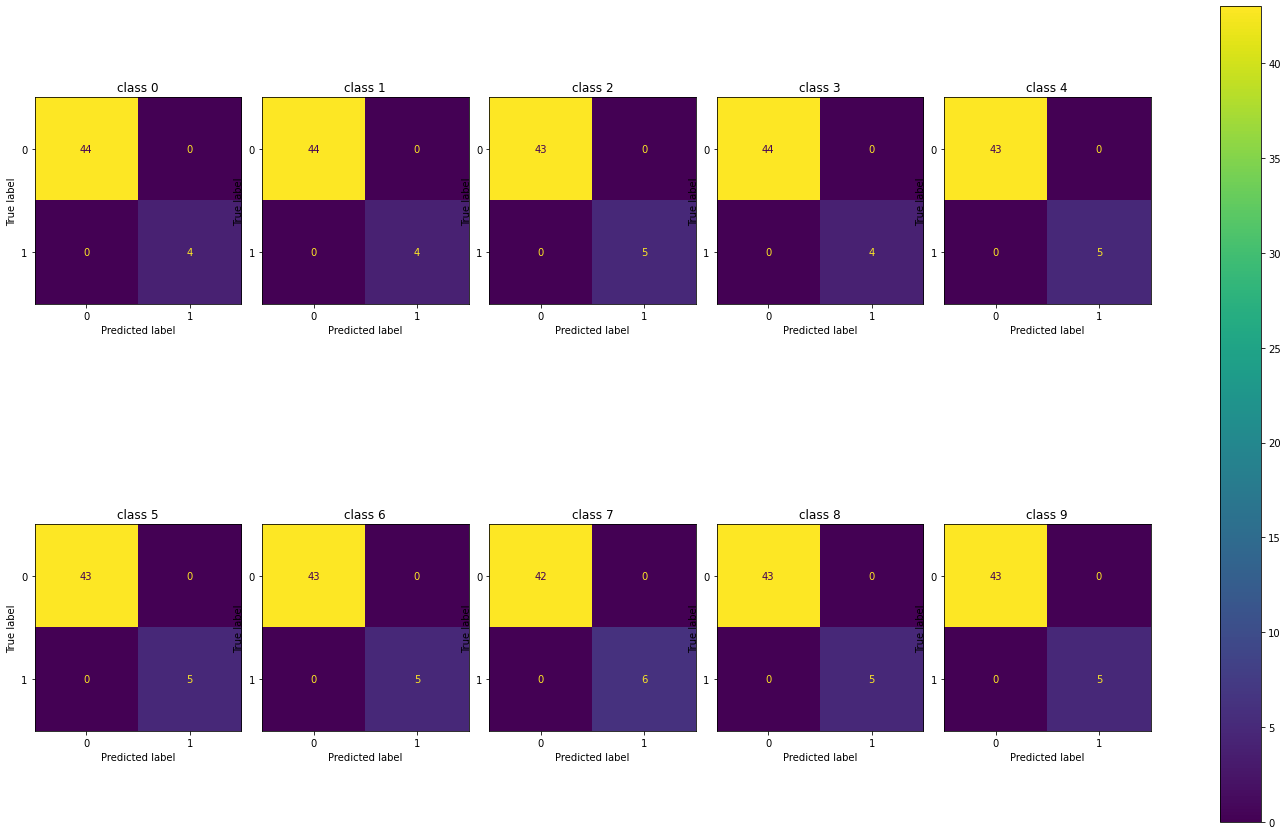

ApplyEyeMakeup:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      1.00      1.00         4

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48

ApplyLipstick:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      1.00      1.00         4

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48

Archery:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00         5

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00 

In [53]:
labels = np.unique(train_class)

#as_dict={}
cr_dict={}

f, axes = plt.subplots(2, 5, figsize=(25, 15))
axes = axes.ravel()
for i in range(len(labels)):
    y_true_label = np.asarray(y_test)[:, i]
    y_pred_label = rounded_predictions[:, i].round()
    #as_dict[labels[i]] = accuracy_score(y_pred=y_pred_label, y_true=y_true_label)    
    cr_dict[labels[i]] = classification_report(y_pred=y_pred_label, y_true=y_true_label)
    disp = ConfusionMatrixDisplay(confusion_matrix(y_pred=y_pred_label, y_true=y_true_label))
    disp.plot(ax=axes[i])
    disp.ax_.set_title(f'class {i}')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.savefig(sec_path + 'ConfusionMatrixDisplay_v%d.png'%VERSION)
plt.show()   


for label, report in cr_dict.items():
    print("{}:".format(label))
    print(report)
    


In [46]:
# new instance where we do not know the answer
image_p = glob("final_p/*.jpeg")
final = get_frames(image_p)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 294.34it/s]


In [47]:
# make a prediction
ynew = final_model.predict(final)

In [48]:
# show the inputs and predicted outputs
print("Predicted=%s" % (ynew[0]))

Predicted=[9.9805427e-01 6.1292906e-04 5.7971603e-05 1.3997909e-05 2.0998999e-04
 9.1216476e-05 6.3230982e-06 2.8637123e-06 7.1016647e-04 2.4021481e-04]


In [51]:
print("X=%s, Predicted=%s" % (final[0], ynew[0]))

X=[[[[-0.06250589 -0.20697647 -0.23403922]
   [-0.05858433 -0.2030549  -0.23011765]
   [-0.05466276 -0.19913334 -0.22619608]
   ...
   [-0.38799608 -0.4501137  -0.37521568]
   [-0.40368235 -0.45795685 -0.40266666]
   [-0.38799608 -0.45795685 -0.40266666]]

  [[-0.06642746 -0.21089804 -0.23796079]
   [-0.05858433 -0.2030549  -0.23011765]
   [-0.05466276 -0.19913334 -0.22619608]
   ...
   [-0.3958392  -0.45795685 -0.38305882]
   [-0.39976078 -0.45795685 -0.39090195]
   [-0.38799608 -0.45795685 -0.40266666]]

  [[-0.06642746 -0.21089804 -0.23796079]
   [-0.06250589 -0.20697647 -0.23403922]
   [-0.05466276 -0.19913334 -0.22619608]
   ...
   [-0.39976078 -0.45795685 -0.37913725]
   [-0.39976078 -0.45795685 -0.39090195]
   [-0.3958392  -0.45795685 -0.4105098 ]]

  ...

  [[-0.3213294  -0.3912902  -0.30462745]
   [-0.24681962 -0.3167804  -0.23011765]
   [-0.22721177 -0.29717255 -0.2105098 ]
   ...
   [-0.2742706  -0.39913332 -0.45756862]
   [-0.27034903 -0.39521176 -0.45364705]
   [-0.2742706